In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import linregress
dj.config["filepath_checksum_size_limit"] = 1000
import os
from ms_stim_analysis.AnalysisTables.sequence_compression import CompressionIndexParams, CompressionIndexSelection, CompressionIndex
from ms_stim_analysis.Analysis.utils import filter_opto_data
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1


[2025-09-04 15:48:10,993][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [2]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}


# analysis_id = "peak_delay_times"

# # (ExportSelection & {**paper_key, "analysis_id": analysis_id}).delete()

# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[15:48:41][INFO] Spyglass: Starting {'export_id': 55}


In [3]:
exclude_simultaneous = False
track = "early_wtrack"
dlc_pos = track != "lineartrack"

results = {}


from ms_stim_analysis.Style.style_guide import animal_style

animal_list = animal_style.index.values
animal_list = [
    x
    for x in animal_list
    if x not in ["control", "transfected", "Banner", "Odins", "Dan"]
]
animal_list.extend(["control", "transfected"])

# animal_list = ["Yoshi", "Winnie"]
# animal_list = ["transfected", "control"]

In [5]:
# results.pop("control")
# results.pop("transfected")

In [5]:
min_spikes_fast = 1
min_spikes_slow = 1

# results = {}

for animal in animal_list:
    if animal in results:
        continue
    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "track_type": track,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    dataset = filter_opto_data(dataset_key)
    # if animal in ["control", "transfected"]:
    #     for exclude_animal in ["Olive", "Frodo", "Bilbo"]:
    #         dataset = dataset - f"nwb_file_name LIKE '{exclude_animal}%'"

    query = CompressionIndex() & (
        dataset.proj(decoding_interval="interval_list_name").fetch("KEY")
    )
    slow_query = query & "compression_index_params_name LIKE '0720v3_slow%'"
    fast_query = query & "compression_index_params_name LIKE 'default%'"
    # query =
    # query = query & "encoding_interval LIKE '%valid times'"
    control_slow_query = slow_query & "encoding_interval LIKE '%control_interval'"
    test_slow_query = slow_query & "encoding_interval LIKE '%test_interval'"
    control_fast_query = fast_query & "encoding_interval LIKE '%control_interval'"
    test_fast_query = fast_query & "encoding_interval LIKE '%test_interval'"

    control_slow_df = control_slow_query.fetch_delays_dataframes()
    test_slow_df = test_slow_query.fetch_delays_dataframes()
    control_fast_df = control_fast_query.fetch_delays_dataframes()
    test_fast_df = test_fast_query.fetch_delays_dataframes()

    control_slow_df = control_slow_df[control_slow_df.n_coincidients >= min_spikes_slow]
    test_slow_df = test_slow_df[test_slow_df.n_coincidients >= min_spikes_slow]
    control_fast_df = control_fast_df[control_fast_df.n_coincidients >= min_spikes_fast]
    test_fast_df = test_fast_df[test_fast_df.n_coincidients >= min_spikes_fast]

    merged_control_df = pd.merge(
        control_slow_df,
        control_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    merged_test_df = pd.merge(
        test_slow_df,
        test_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    results_i = {
        "control": merged_control_df,
        "test": merged_test_df,
    }

    results[animal] = results_i

[15:59:30][WARNING] Spyglass: Cannot export log join for
<class 'ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol.OptoStimProtocolLaser'>


datasets: 9


[2025-09-04 15:59:51,731][WARNING]: Skipped checksum for file with hash: e5c9492f-bc8f-344a-babf-6fb96113209a, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_U34F3O66W6.nwb
[2025-09-04 15:59:51,739][WARNING]: Skipped checksum for file with hash: e5c9492f-bc8f-344a-babf-6fb96113209a, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_U34F3O66W6.nwb
[2025-09-04 15:59:51,802][WARNING]: Skipped checksum for file with hash: db68da71-4961-3fda-c326-0c432964e144, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_YT74KDXLYM.nwb
[2025-09-04 15:59:51,809][WARNING]: Skipped checksum for file with hash: db68da71-4961-3fda-c326-0c432964e144, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_YT74KDXLYM.nwb
[2025-09-04 15:59:51,862][WARNING]: Skipped checksum for file with hash: 5ddf7736-c692-2653-2348-c68bcc1d9c6e, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_HMATUSSVSB.nwb
[2025-09-04 15:59:51,869][WARNING]: Skipped checksum for file wit

datasets: 9


[2025-09-04 16:03:22,607][WARNING]: Skipped checksum for file with hash: 4ef963b4-7403-5900-ec65-04fe5e0991f4, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_8HJ7FXWIC7.nwb
[2025-09-04 16:03:22,614][WARNING]: Skipped checksum for file with hash: 4ef963b4-7403-5900-ec65-04fe5e0991f4, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_8HJ7FXWIC7.nwb
[2025-09-04 16:03:22,673][WARNING]: Skipped checksum for file with hash: 2a528d58-e639-734b-bdbd-d94d7326e3c6, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_QNX3YFXE63.nwb
[2025-09-04 16:03:22,680][WARNING]: Skipped checksum for file with hash: 2a528d58-e639-734b-bdbd-d94d7326e3c6, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_QNX3YFXE63.nwb
[2025-09-04 16:03:22,736][WARNING]: Skipped checksum for file with hash: bca2510a-26e0-d74c-fb4a-6f5c7c8d2181, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_I8VTWEZKGT.nwb
[2025-09-04 16:03:22,741][WARNING]: Skipped checksum for file with hash: bc

datasets: 10


[2025-09-04 16:10:04,886][WARNING]: Skipped checksum for file with hash: e0dbbed7-4a20-f4a5-e69e-014ce209250d, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_E1CUSAIZF3.nwb
[2025-09-04 16:10:04,893][WARNING]: Skipped checksum for file with hash: e0dbbed7-4a20-f4a5-e69e-014ce209250d, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_E1CUSAIZF3.nwb
[2025-09-04 16:10:04,957][WARNING]: Skipped checksum for file with hash: a8f07794-14bf-540f-669e-0320d9066928, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_BSK430TRHQ.nwb
[2025-09-04 16:10:04,965][WARNING]: Skipped checksum for file with hash: a8f07794-14bf-540f-669e-0320d9066928, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_BSK430TRHQ.nwb
[2025-09-04 16:10:05,021][WARNING]: Skipped checksum for file with hash: 04a77b12-ef27-ac7e-7e9a-660aff2c334e, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_ZPRIQ5V6RO.nwb
[2025-09-04 16:10:05,028][WARNING]: Skipped checksum for file wit

datasets: 10


[2025-09-04 16:13:31,336][WARNING]: Skipped checksum for file with hash: a02f3015-e520-8b97-5d01-21af3daaa7f2, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_G10B79W1WN.nwb
[2025-09-04 16:13:31,342][WARNING]: Skipped checksum for file with hash: a02f3015-e520-8b97-5d01-21af3daaa7f2, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_G10B79W1WN.nwb
[2025-09-04 16:13:31,400][WARNING]: Skipped checksum for file with hash: b612f46d-bfb0-8693-3b58-1ebc86d3045d, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_FVWI3XXWBR.nwb
[2025-09-04 16:13:31,406][WARNING]: Skipped checksum for file with hash: b612f46d-bfb0-8693-3b58-1ebc86d3045d, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_FVWI3XXWBR.nwb
[2025-09-04 16:13:31,456][WARNING]: Skipped checksum for file with hash: e52c33bf-3688-c2d3-0ded-2484d89859e2, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_HUL2TSJ2MJ.nwb
[2025-09-04 16:13:31,463][WARNING]: Skipped checksum for file wit

datasets: 8


[2025-09-04 16:17:02,396][WARNING]: Skipped checksum for file with hash: f0b68b69-6d47-d60e-8892-c30b7cae49ea, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_VECJ79J89W.nwb
[2025-09-04 16:17:02,403][WARNING]: Skipped checksum for file with hash: f0b68b69-6d47-d60e-8892-c30b7cae49ea, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_VECJ79J89W.nwb
[2025-09-04 16:17:02,461][WARNING]: Skipped checksum for file with hash: fd48bc36-6786-0825-8449-fa6c47e7c9fd, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_VE7GNAGFY0.nwb
[2025-09-04 16:17:02,468][WARNING]: Skipped checksum for file with hash: fd48bc36-6786-0825-8449-fa6c47e7c9fd, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_VE7GNAGFY0.nwb
[2025-09-04 16:17:02,521][WARNING]: Skipped checksum for file with hash: 622a22de-9420-fd0c-b2a9-f4851bba1b85, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_WAMANY0JWE.nwb
[2025-09-04 16:17:02,528][WARNING]: Skipped checksum for file with hash: 62

datasets: 16


[2025-09-04 16:20:38,153][WARNING]: Skipped checksum for file with hash: 331f2399-53b4-b45c-8d5f-eb91530f54c4, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_J6HIK12MCL.nwb
[2025-09-04 16:20:38,160][WARNING]: Skipped checksum for file with hash: 331f2399-53b4-b45c-8d5f-eb91530f54c4, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_J6HIK12MCL.nwb
[2025-09-04 16:20:38,220][WARNING]: Skipped checksum for file with hash: 9866e820-3c1f-192f-fb17-1f6726b60293, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_DJ9HPK8YT7.nwb
[2025-09-04 16:20:38,227][WARNING]: Skipped checksum for file with hash: 9866e820-3c1f-192f-fb17-1f6726b60293, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_DJ9HPK8YT7.nwb
[2025-09-04 16:20:38,283][WARNING]: Skipped checksum for file with hash: 53c6c2c0-a4ae-6aa7-203e-f84a224cabdd, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_P8072O6CW9.nwb
[2025-09-04 16:20:38,291][WARNING]: Skipped checksum for file with hash: 53

datasets: 8


[2025-09-04 16:26:47,740][WARNING]: Skipped checksum for file with hash: 06afba65-e68a-23d1-2cd8-24b88796b121, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_45LJIMDTNE.nwb
[2025-09-04 16:26:47,748][WARNING]: Skipped checksum for file with hash: 06afba65-e68a-23d1-2cd8-24b88796b121, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_45LJIMDTNE.nwb
[2025-09-04 16:26:47,807][WARNING]: Skipped checksum for file with hash: a4016c1e-700c-47a6-d949-5a9ab7f486f6, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_TZKRNGCUGI.nwb
[2025-09-04 16:26:47,815][WARNING]: Skipped checksum for file with hash: a4016c1e-700c-47a6-d949-5a9ab7f486f6, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_TZKRNGCUGI.nwb
[2025-09-04 16:26:47,870][WARNING]: Skipped checksum for file with hash: 09928c23-0ae0-16e8-3cff-933db6a36037, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_E2G51GJLXV.nwb
[2025-09-04 16:26:47,876][WARNING]: Skipped checksum for file with hash: 09

datasets: 42


[2025-09-04 16:33:21,286][WARNING]: Skipped checksum for file with hash: 06afba65-e68a-23d1-2cd8-24b88796b121, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_45LJIMDTNE.nwb
[2025-09-04 16:33:21,294][WARNING]: Skipped checksum for file with hash: 06afba65-e68a-23d1-2cd8-24b88796b121, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_45LJIMDTNE.nwb
[2025-09-04 16:33:21,352][WARNING]: Skipped checksum for file with hash: a4016c1e-700c-47a6-d949-5a9ab7f486f6, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_TZKRNGCUGI.nwb
[2025-09-04 16:33:21,359][WARNING]: Skipped checksum for file with hash: a4016c1e-700c-47a6-d949-5a9ab7f486f6, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_TZKRNGCUGI.nwb
[2025-09-04 16:33:21,413][WARNING]: Skipped checksum for file with hash: 09928c23-0ae0-16e8-3cff-933db6a36037, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_E2G51GJLXV.nwb
[2025-09-04 16:33:21,422][WARNING]: Skipped checksum for file with hash: 09

datasets: 44


[2025-09-04 16:36:08,166][WARNING]: Skipped checksum for file with hash: 4ef963b4-7403-5900-ec65-04fe5e0991f4, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_8HJ7FXWIC7.nwb
[2025-09-04 16:36:08,174][WARNING]: Skipped checksum for file with hash: 4ef963b4-7403-5900-ec65-04fe5e0991f4, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_8HJ7FXWIC7.nwb
[2025-09-04 16:36:08,237][WARNING]: Skipped checksum for file with hash: 2a528d58-e639-734b-bdbd-d94d7326e3c6, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_QNX3YFXE63.nwb
[2025-09-04 16:36:08,246][WARNING]: Skipped checksum for file with hash: 2a528d58-e639-734b-bdbd-d94d7326e3c6, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_QNX3YFXE63.nwb
[2025-09-04 16:36:08,307][WARNING]: Skipped checksum for file with hash: bca2510a-26e0-d74c-fb4a-6f5c7c8d2181, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_I8VTWEZKGT.nwb
[2025-09-04 16:36:08,316][WARNING]: Skipped checksum for file with hash: bc

## SLOW:FAST Distribution delay peak version

In [6]:
def get_max_fast_peak_delay(row):
    fast_bins = np.arange(-200, 199) + 0.5
    ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
    peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
    return fast_bins[ind_relevant][peak_ind]

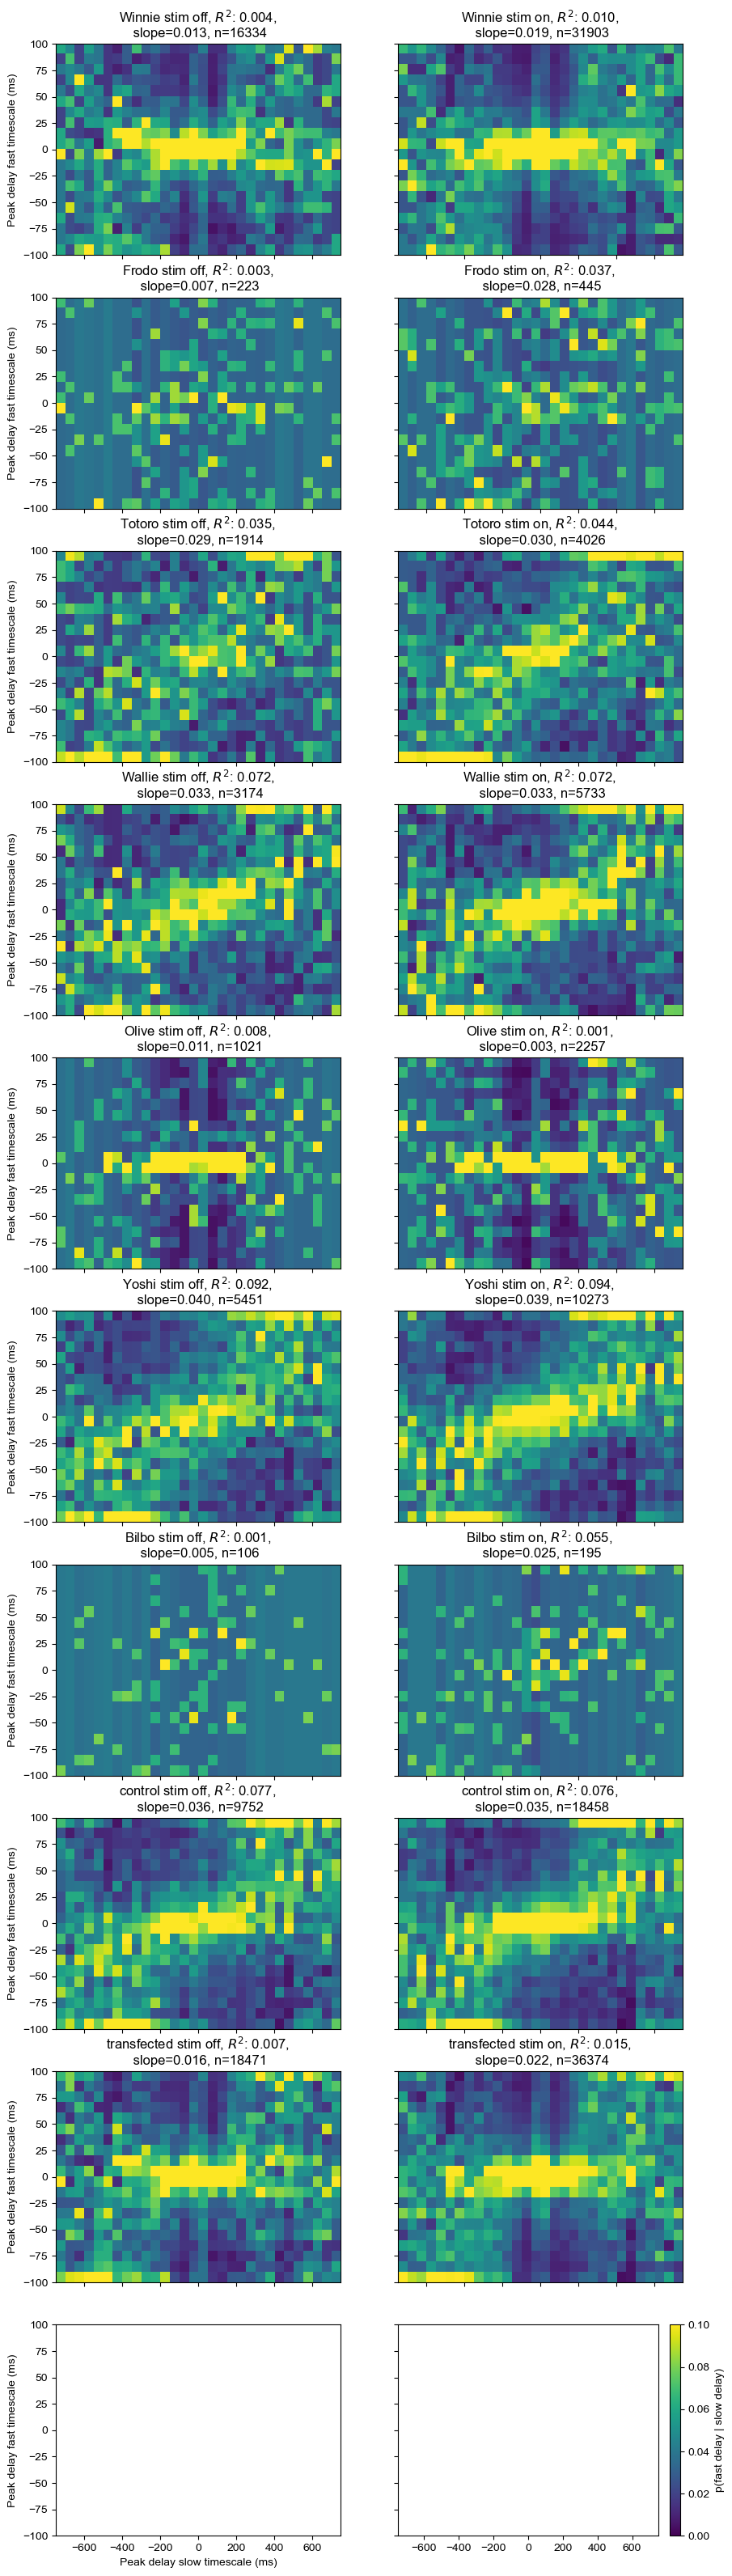

In [ ]:
# import pandas as pd
import matplotlib.pyplot as plt

min_slow_spikes = 100
min_fast_spikes = 50
#############3
upsample = 0
sigma_slow = 5
sigma_fast = 5
log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 50
fast_bin_size = 10
plot_ridge = False
long_timescale_thresh = 200
plot_fit = False
correlation_range = 750
# upsample = 300
# sigma_slow = 30
# sigma_fast = 10
# log = False
# standardize_orders = False
# modulo_shift = 0
# slow_bin_size = 10
# fast_bin_size = 1
# plot_ridge = False
# long_timescale_thresh = 200
# correlation_range = 750
# slow_bin_size = 16
# fast_bin_size = 6
# slow_bin_size = 2
# fast_bin_size = 1
heatmap_results = {}
fast_distribution = {}
slow_distribution = {}
counts = {}
correlations = {}
slopes = {}
long_timescale_counts = {}
fig, ax = plt.subplots(
    ncols=2,
    nrows=len(results) + 1,
    sharex=True,
    sharey=True,
    figsize=(10, 4 * (len(results) + 1)),
    # width_ratios=(1, 1, 0.2)
)
for a, animal in zip(ax, results.keys()):
    # if animal == "Winnie":
    #     continue
    heatmap_results[animal] = {}
    fast_distribution[animal] = {}
    slow_distribution[animal] = {}
    counts[animal] = {}
    long_timescale_counts[animal] = {}
    correlations[animal] = {}
    slopes[animal] = {}
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]
    merged_control_df = merged_control_df[
        merged_control_df.n_coincidients_fast >= min_fast_spikes
    ]
    merged_test_df = merged_test_df[
        merged_test_df.n_coincidients_fast >= min_fast_spikes
    ]
    merged_control_df = merged_control_df[
        merged_control_df.n_coincidients_slow >= min_slow_spikes
    ]
    merged_test_df = merged_test_df[
        merged_test_df.n_coincidients_slow >= min_slow_spikes
    ]
    lim_x = correlation_range + 1
    # lim_x = 201
    if standardize_orders:
        bx = np.arange(0, lim_x, slow_bin_size)
    else:
        bx = np.arange(-lim_x, lim_x, slow_bin_size)
    by = np.arange(-120, 120.1, fast_bin_size)
    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        # fast_val = merged_df.peak_delay_fast.values.copy()
        fast_val = np.array(
            [get_max_fast_peak_delay(row) for _, row in merged_df.iterrows()]
        )
        raw_slow_val = slow_val.copy()
        raw_fast_val = fast_val.copy()
        counts[animal][cond] = len(merged_df)
        long_timescale_counts[animal][cond] = np.sum(
            np.abs(slow_val > long_timescale_thresh)
        )
        if upsample > 1:
            slow_val = [x for x in slow_val for _ in range(upsample)]
            fast_val = [x for x in fast_val for _ in range(upsample)]
            slow_val = np.array(slow_val) + np.random.normal(
                0, sigma_slow, len(slow_val)
            )
            fast_val = np.array(fast_val) + np.random.normal(
                0, sigma_fast, len(fast_val)
            )
        if standardize_orders:
            ind = np.where(slow_val < 0)[0]
            slow_val[ind] = -slow_val[ind]
            fast_val[ind] = -fast_val[ind]
        if modulo_shift:
            ind = np.where(np.abs(slow_val) < 200)[0]
            steps = np.arange(0, 500, modulo_shift)
            sub_outer = np.subtract.outer(
                slow_val,
                steps,
            )
            min_offset = np.argmin(np.abs(sub_outer), axis=1)
            slow_val = np.array(
                [sub_outer[i, min_offset[i]] for i in range(len(min_offset))]
            )
            slow_val = slow_val[ind]
            fast_val = fast_val[ind]
        dist_slow = np.histogram(slow_val, bins=bx)[0]
        dist_slow = dist_slow / dist_slow.sum()
        slow_distribution[animal][cond] = dist_slow
        dist_fast = np.histogram(fast_val, bins=by)[0]
        dist_fast = dist_fast / dist_fast.sum()
        fast_distribution[animal][cond] = dist_fast
        H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
        H = H + 1
        H = H / H.sum(axis=1)[:, None]
        # H = H / H.sum()
        if log:
            H = np.log10(H + 1e-10)  # Log transform to visualize better
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                cmap="hot",
                aspect="auto",
                clim=(-2, -1),
            )
        else:
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(0, 0.1),
                # clim=(0, 0.25),
            )
        if plot_ridge:
            a_i.plot(bx[1:], by[np.argmax(H, axis=1)], c="cyan")
        # ind_corr = np.where(np.abs(raw_slow_val) <= correlation_range)[0]
        ind_corr = np.logical_and(
            np.abs(raw_slow_val) <= correlation_range, np.abs(raw_fast_val) <= 90
        )
        corr = np.corrcoef(
            raw_slow_val[ind_corr],
            raw_fast_val[ind_corr],
        )[0, 1]
        correlations[animal][cond] = corr
        slope = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr]).slope
        slopes[animal][cond] = slope
        a_i.set_title(
            f"{animal} {cond}, $R^2$: {corr**2:.3f}, \n slope={slope:.3f}, n={counts[animal][cond]}"
        )
        heatmap_results[animal][cond] = H
        if plot_fit:
            # Fit a line to the data
            x_fit = np.linspace(bx[0], bx[-1], 100)
            lin_fit = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr])
            slope = lin_fit.slope
            intercept = lin_fit.intercept
            # Generate y values for the fit line
            y_fit = slope * x_fit + intercept
            a_i.plot(x_fit, y_fit, color="cyan", linestyle="--", linewidth=1)
        # break
# plt.colorbar(label='Counts')
lim = correlation_range
if modulo_shift:
    plt.xlim(-modulo_shift // 2, modulo_shift // 2)
elif standardize_orders:
    plt.xlim(0, lim)
else:
    plt.xlim(-lim, lim)
for a in ax[-1, :-1]:
    # a.set_ylim(-80, 80)
    a.set_ylim(-100, 100)
    xlabel = "Peak delay slow timescale (ms)"
    if modulo_shift:
        xlabel = f"Peak delay slow timescale (ms) modulo {modulo_shift}, shifted"
    a.set_xlabel(xlabel)
for a in ax[:, 0]:
    a.set_ylabel("Peak delay fast timescale (ms)")
    # a.set_xticks(np.arange(-lim, lim + 1, 100))
    # a.set_yticks(np.arange(-80, 81, 20))

im = ax[0, 0].images[0]
if im is not None:
    plt.colorbar(
        im,
        ax=ax[-1, -1],
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
        label="p(fast delay | slow delay)",
    )
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"

plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_S3/Fig_S3d_wtrack_slow_fast_peak_delay.svg")

stim off
stim on


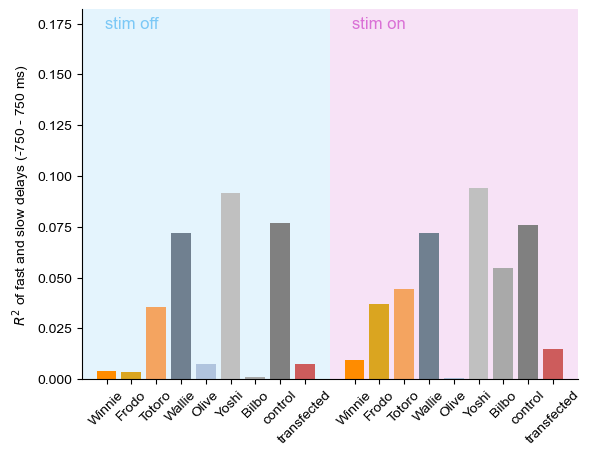

In [10]:
from ms_stim_analysis.Style.style_guide import interval_style

fig = plt.figure()

ticks = []
labels = []
for i, cond in enumerate(["stim off", "stim on"]):
    print(cond)
    for j, animal in enumerate(results.keys()):
        # if animal not in correlations:
        #     continue
        corr = correlations[animal][cond] ** 2
        color = animal_style.loc[animal, "color"]
        xloc = i * 10 + j
        ticks.append(xloc)
        labels.append(f"{animal}")
        plt.bar(
            xloc,
            corr,
            color=color,
            # label=animal,
        )
plt.xticks(ticks, labels, rotation=45)
plt.fill_between(
    [-1, 9], 0, 0.2, facecolor=interval_style["control"], alpha=0.2, zorder=-1
)
plt.fill_between(
    [9, 19], 0, 0.2, facecolor=interval_style["test"], alpha=0.2, zorder=-1
)

plt.text(
    1.0,
    0.175,
    "stim off",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["control"],
)
plt.text(
    11.0,
    0.175,
    "stim on",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["test"],
)
plt.ylabel(
    f"$R^2$ of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-1, 19)
plt.ylim(0, 0.182)
fig.gca().spines[["top", "right"]].set_visible(False)

# ax.set_title(f"Correlation of slow and fast delays {cond}")
# ax.set_ylabel("Correlation coefficient")
# ax.set_xlabel("Animal")
# ax.axhline(0, ls="--", c="k")
# ax.legend()

stim off
stim on


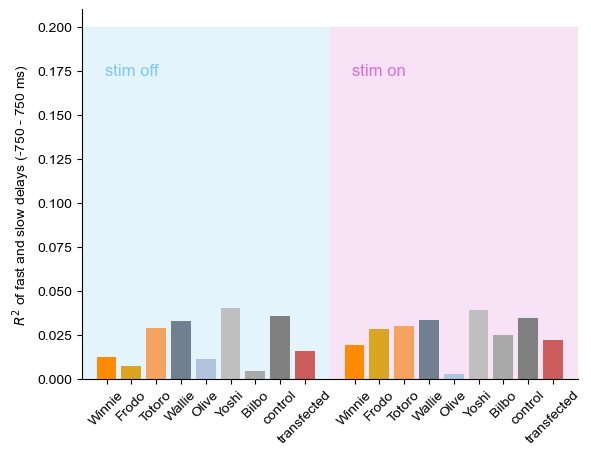

In [11]:
# fig = plt.figure()

ticks = []
labels = []
for i, cond in enumerate(["stim off", "stim on"]):
    print(cond)
    for j, animal in enumerate(results.keys()):
        # if animal not in correlations:
        #     continue
        slope = slopes[animal][cond]  # **-1
        color = animal_style.loc[animal, "color"]
        xloc = i * 10 + j
        ticks.append(xloc)
        labels.append(f"{animal}")
        plt.bar(
            xloc,
            slope,
            color=color,
            # label=animal,
        )
plt.xticks(ticks, labels, rotation=45)
plt.fill_between(
    [-1, 9], 0, 0.2, facecolor=interval_style["control"], alpha=0.2, zorder=-1
)
plt.fill_between(
    [9, 19], 0, 0.2, facecolor=interval_style["test"], alpha=0.2, zorder=-1
)

plt.text(
    1.0,
    0.175,
    "stim off",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["control"],
)
plt.text(
    11.0,
    0.175,
    "stim on",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["test"],
)
plt.ylabel(
    f"$R^2$ of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-1, 19)
# plt.ylim(0, 0.182)
fig.gca().spines[["top", "right"]].set_visible(False)

# ax.set_title(f"Correlation of slow and fast delays {cond}")
# ax.set_ylabel("Correlation coefficient")
# ax.set_xlabel("Animal")
# ax.axhline(0, ls="--", c="k")
# ax.legend()

# Heirarchical Bootstrap of correlation coefficients (NO OLIVE)

In [13]:
correlation_range = 500
fast_correlation_range = 90
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

from ms_stim_analysis.Style.style_guide import animal_style, interval_style
from ms_stim_analysis.Analysis.utils import violin_scatter

In [14]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        c_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])
            corr = np.corrcoef(slow_val, fast_val)[0, 1]
            c_.append(corr)
        c_ = np.array(c_)
        bootstrap_results[group][cond] = c_

Bootstrapping targeted test: 100%|██████████| 10000/10000 [01:09<00:00, 143.07it/s]


interval effect (control animals) p-value: 0.406
interval effect (targeted animals) p-value: 0.243
group effect (control interval) p-value: 0.001
group effect (test interval) p-value: 0.001


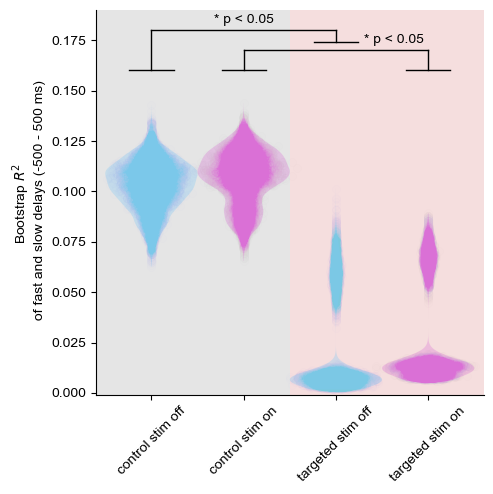

In [18]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond] ** 2
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [
        bootstrap_results[group]["control"] ** 2,
        bootstrap_results[group]["test"] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond] ** 2,
        bootstrap_results["targeted"][cond] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")

# indicate sig difference
y_max = 0.16
y_bridge = 0.17
x1 = ticks[1]
x2 = ticks[3]
bar_rng = 0.12
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.65,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
    color="k",
)

# indicate sig difference
y_max = 0.16, 0.174
y_bridge = 0.18
x1 = ticks[0]
x2 = ticks[2]
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
plt.text(
    (x1 + x2) / 2,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)

plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.2,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.2,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.001, 0.19)

fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "../Figures/Fig_S3/Fig_S3e_wtrack_slow_fast_heirarchical_bootstrap_correlation_coefficients.svg"
)

### Pooling stim on off

In [19]:
correlation_range = 500
fast_correlation_range = 90
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [20]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        temp_slow = []
        temp_fast = []
        for cond in ["control", "test"]:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            # fast_val = fast_val%100

            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            temp_slow.extend(slow_val[ind_valid])
            temp_fast.extend(fast_val[ind_valid])

        df = pd.DataFrame(
            {
                "peak_delay_slow": temp_slow,
                "peak_delay_fast": temp_fast,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group}"):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        slow_val = []
        fast_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            slow_val.extend(df.peak_delay_slow.values[pair_samples])
            fast_val.extend(df.peak_delay_fast.values[pair_samples])
        corr = np.corrcoef(slow_val, fast_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted: 100%|██████████| 10000/10000 [01:47<00:00, 92.81it/s]


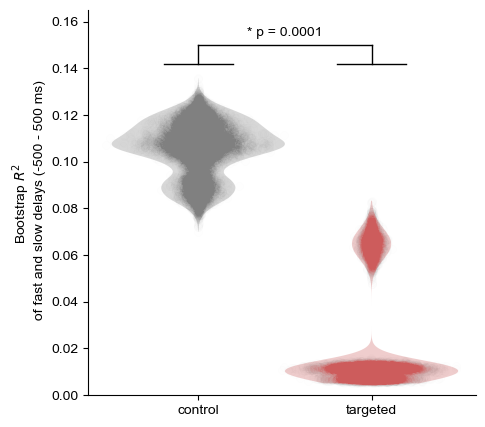

In [21]:
fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    scores = bootstrap_results[group] ** 2  # square the scores
    color = animal_style.loc[group if group == "control" else "transfected", "color"]
    violin_scatter(scores, pos=[i / 2], color=color)


plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)

p_val = test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["targeted"]
)

# indicate sig difference
y_max = 0.142
y_bridge = 0.15
x1 = 0
x2 = 0.5
bar_rng = 0.1
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.5,
    y_bridge + 0.005,
    f"* p = {p_val:.4f}",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)
plt.ylim(0, 0.165)
fig.gca().spines[["top", "right"]].set_visible(False)

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/bootstrap_slowFast_ExcludeAnimals_Rsquared_POOLED.svg"
# )

# Fast-Fast heatmap

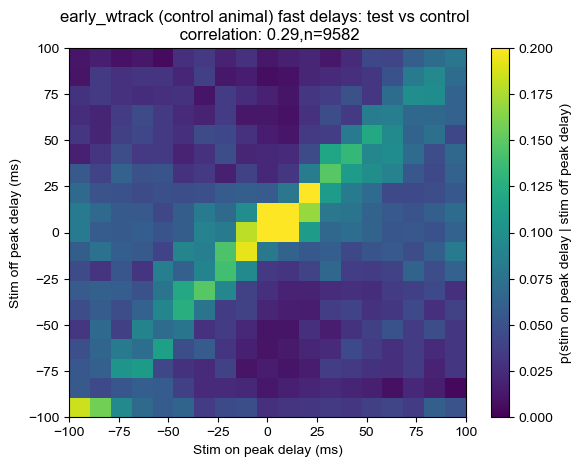

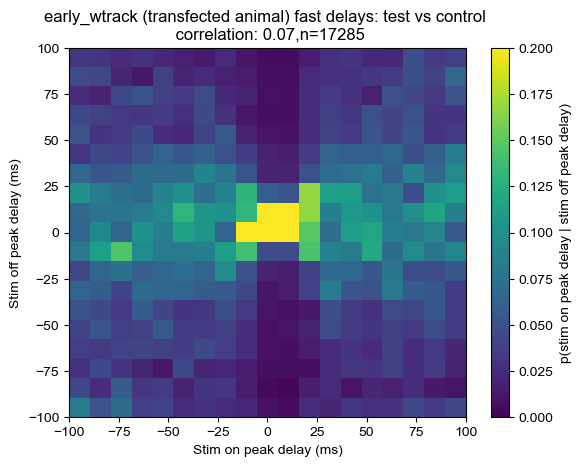

In [24]:
animal = "transfected"
# animal = "control"

for animal in ["control", "transfected"]:
    min_coincidients = 50
    fig = plt.figure()
    merged_df = pd.merge(
        results[animal]["test"],
        results[animal]["control"],
        how="inner",
        on=["s_id_1", "s_id_2"],
    )
    merged_df = merged_df[
        np.logical_and(
            merged_df.n_coincidients_fast_x > min_coincidients,
            merged_df.n_coincidients_fast_y > min_coincidients,
        )
    ]

    test_df = merged_df.copy()
    test_df = test_df.rename(
        columns={
            "cross_corr_fast_x": "cross_corr_fast",
        }
    )
    test_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
    )

    control_df = merged_df.copy()
    control_df = control_df.rename(
        columns={
            "cross_corr_fast_y": "cross_corr_fast",
        }
    )
    control_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
    )

    # plt.scatter(test_delays, control_delays, alpha=0.2)
    H = np.histogram2d(
        control_delays,
        test_delays,
        bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
    )[0]
    H = H / H.sum(axis=1)[:, None]  #
    # H = H/H.sum()

    plt.imshow(
        H.T,
        origin="lower",
        extent=(-100, 100, -100, 100),
        # cmap="Blues",
        aspect="auto",
        clim=(0, 0.2),
    )
    plt.colorbar(label="p(stim on peak delay | stim off peak delay)")
    # plt.clim(0.1)
    #
    np.corrcoef(test_delays, control_delays)[0, 1]

    plt.title(
        f"{track} ({animal} animal) fast delays: test vs control \n correlation: {np.corrcoef(test_delays, control_delays)[0, 1]:.2f},n={len(test_delays)}"
    )

    plt.xlabel("Stim on peak delay (ms)")
    plt.ylabel("Stim off peak delay (ms)")

    fig.savefig(
        f"../Figures/Fig_S3/Fig_S3b_fast_peak_delay_test_vs_control_{animal}_animals.svg"
    )

In [25]:
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [26]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        merged_df = pd.merge(
            results[animal]["test"],
            results[animal]["control"],
            how="inner",
            on=["s_id_1", "s_id_2"],
        )

        test_df = merged_df.copy()
        test_df = test_df.rename(
            columns={
                "cross_corr_fast_x": "cross_corr_fast",
            }
        )
        test_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
        )

        control_df = merged_df.copy()
        control_df = control_df.rename(
            columns={
                "cross_corr_fast_y": "cross_corr_fast",
            }
        )
        control_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
        )

        df = pd.DataFrame(
            {
                "control_delays": control_delays,
                "test_delays": test_delays,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} "):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        control_val = []
        test_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            control_val.extend(df.control_delays.values[pair_samples])
            test_val.extend(df.test_delays.values[pair_samples])
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted : 100%|██████████| 10000/10000 [00:39<00:00, 255.52it/s]


Bootstrap test p-value: 0.00097794


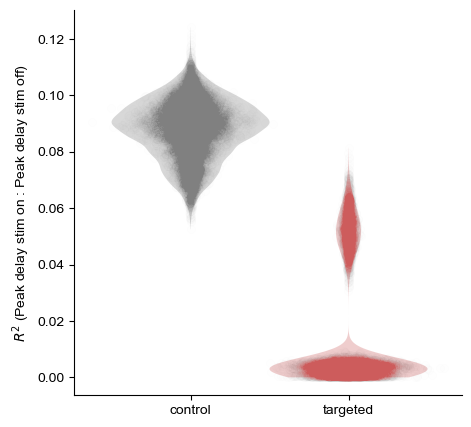

In [28]:
fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal] ** 2
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("$R^2$ (Peak delay stim on : Peak delay stim off)")

fig.savefig(
    "../Figures/Fig_S3/Fig_S3b_fast_peak_delay_test_vs_control_R2_bootstrap.svg"
)

print(
    f"Bootstrap test p-value: {test_diff_of_bootstrap_dist(bootstrap_results['control'], bootstrap_results['targeted'])}"
)

# Fast cross correlogram grouped by slow delays

Text(0.5, 1.0, 'Yoshi wtrack stim on')

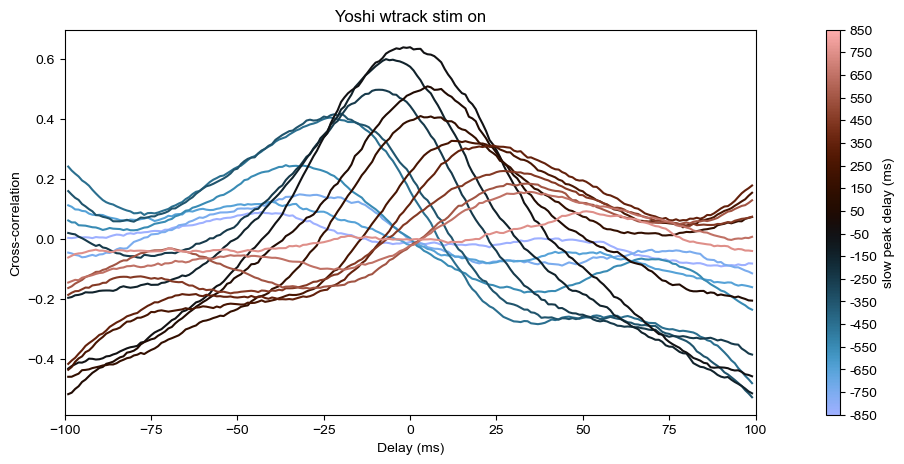

In [35]:
import matplotlib as mpl

animal = "transfected"
animal = "Yoshi"
cond = "test"

df = results[animal][cond]

delay_bins = np.arange(-550, 551, 100)
delay_bins = np.arange(-850, 851, 100)

fig, ax = plt.subplots(figsize=(10, 5), ncols=2, width_ratios=[1, 0.02])
delta_t = np.arange(-200, 200, 1)  # Time lags for cross-correlation
ind = np.where(np.abs(delta_t) < 100)[0]  # Relevant indices for cross-correlation
peaks = []
peak_val = []
cmap = plt.cm.berlin
for i in range(delay_bins.size - 1):
    color = cmap(i / (delay_bins.size - 1))
    rng = (delay_bins[i], delay_bins[i + 1])
    df_rng = df[
        np.logical_and(df.peak_delay_slow > rng[0], df.peak_delay_slow < rng[1])
    ]
    data = np.array([x for x in df_rng.cross_corr_fast.values])[:, ind]
    data = data - np.mean(data, axis=1)[:, None]
    ax[0].plot(
        delta_t[ind], np.mean(data, axis=0), label="Mean cross-correlation", color=color
    )
    peaks.append(delta_t[ind][np.argmax(np.mean(data, axis=0))])
    peak_val.append(np.max(np.mean(data, axis=0)))

# Create a ScalarMappable for the colorbar using the same colormap and normalization as used for 'color'
norm = mpl.colors.Normalize(vmin=delay_bins[0], vmax=delay_bins[-1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older matplotlib

cbar = plt.colorbar(sm, label="slow peak delay (ms)", cax=ax[1])
cbar.set_ticks(delay_bins)
cbar.set_ticklabels(
    [f"{int(b)}" for b in delay_bins],
)

ax[0].set_xlim(-100, 100)
ax[0].set_xlabel("Delay (ms)")
ax[0].set_ylabel("Cross-correlation")
ax[0].set_title(f"{animal} wtrack {'stim on' if cond == 'test' else 'stim off'}")